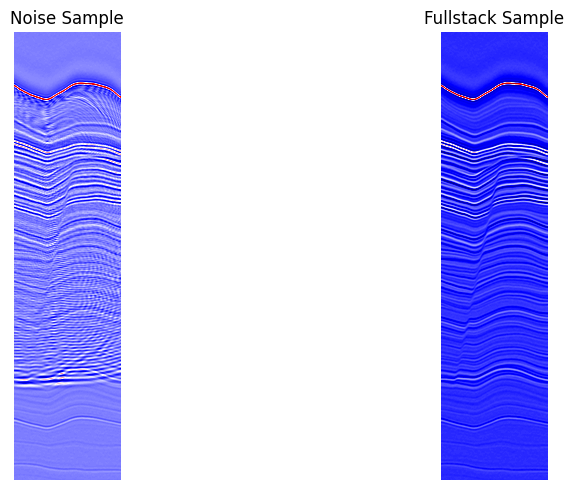

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load a sample noise and fullstack slice
noise_sample_path = "/home/simlab120/Denoise_comp/Processed_Data/part1_noise/noise_42487393_slice_13.npy"
fullstack_sample_path = "/home/simlab120/Denoise_comp/Processed_Data/part1_fullstack/fullstack_42487393_slice_13.npy"

noise_sample = np.load(noise_sample_path)
fullstack_sample = np.load(fullstack_sample_path)

# Plot the noise and fullstack slices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(noise_sample, cmap="seismic")
axes[0].set_title("Noise Sample")
axes[0].axis("off")

axes[1].imshow(fullstack_sample, cmap="seismic")
axes[1].set_title("Fullstack Sample")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [2]:
import os
import numpy as np
import torch
import random
from torch.utils.data import Dataset

class SeismicDataset(Dataset):
    def __init__(self, data_dir, max_samples=1000):
        self.noise_files = []
        self.fullstack_files = []
        subfolder_data = {}  # Store files by subfolder
        
        # Scan all noise subfolders
        for part in os.listdir(data_dir):
            part_path = os.path.join(data_dir, part)
            if "noise" in part:
                fullstack_part = part.replace("noise", "fullstack")
                fullstack_part_path = os.path.join(data_dir, fullstack_part)

                if not os.path.exists(fullstack_part_path):
                    continue  # Skip unmatched subfolders

                files = []
                for file in os.listdir(part_path):
                    noise_file = os.path.join(part_path, file)
                    fullstack_file = os.path.join(fullstack_part_path, file.replace("noise", "fullstack"))

                    if os.path.exists(fullstack_file):
                        files.append((noise_file, fullstack_file))

                if files:
                    subfolder_data[part] = files  # Store valid pairs

        # Distribute samples across subfolders
        all_files = []
        num_folders = len(subfolder_data)
        if num_folders == 0:
            raise ValueError("No valid (noise, fullstack) file pairs found!")

        samples_per_folder = max_samples // num_folders  # Even distribution
        for folder, files in subfolder_data.items():
            selected_files = random.sample(files, min(samples_per_folder, len(files)))  # Select subset
            all_files.extend(selected_files)

        # Ensure we don't exceed max_samples
        if len(all_files) > max_samples:
            all_files = random.sample(all_files, max_samples)

        self.noise_files, self.fullstack_files = zip(*all_files)  # Unzip lists

    def __len__(self):
        return len(self.noise_files)
    
    def __getitem__(self, idx):
        noise = np.load(self.noise_files[idx])
        fullstack = np.load(self.fullstack_files[idx])
        
        noise = torch.tensor(noise, dtype=torch.float32).unsqueeze(0)  # (1, 1259, 300)
        fullstack = torch.tensor(fullstack, dtype=torch.float32).unsqueeze(0)
        
        return noise, fullstack



In [3]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [13]:
pip install UnetPlusPlus

ERROR: Could not find a version that satisfies the requirement UnetPlusPlus (from versions: none)
ERROR: No matching distribution found for UnetPlusPlus
Note: you may need to restart the kernel to use updated packages.


In [4]:
import timm
from segmentation_models_pytorch.decoders.unetplusplus import UnetPlusPlus

/home/simlab120/anaconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class Crop2d(nn.Module):
    def __init__(self, left=10, right=10, top=21, bottom=0):
        super(Crop2d, self).__init__()
        self.left = left
        self.right = right
        self.top = top
        self.bottom = bottom

    def forward(self, x):
        return x[:, :, self.top:x.shape[2] - self.bottom, self.left:x.shape[3] - self.right]

In [6]:
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.encoders import get_encoder

class cnn_model(nn.Module):
    def __init__(self):
        super().__init__()

        # Zero padding before encoding
        self.zero_pad = nn.ZeroPad2d((10, 10, 21, 0))

        # EfficientNet-B3 as the encoder
        self.encoder = timm.create_model("efficientnet_b3", features_only=True, pretrained=True, in_chans=1)

        # UNet++ decoder
        self.decoder = UnetPlusPlus(
            encoder_name="timm-efficientnet-b3",  # Use a supported encoder
            encoder_weights="imagenet",
            in_channels=1,
            classes=1  
        )

        # Cropping after decoding
        self.crop = Crop2d(10, 10, 21, 0)

    def forward(self, x):
        x = self.zero_pad(x)
        x = self.decoder(x)  # Decoder already includes an encoder
        x = self.crop(x)
        return x

    

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from skimage.metrics import structural_similarity as ssim  # Import SSIM
import numpy as np
import torch.cuda.amp as amp  # Mixed precision training

# Initialize dataset
data_dir = "/home/simlab120/Denoise_comp/Processed_Data/"
dataset = SeismicDataset(data_dir)

# Train-Test Split (80% Train, 20% Test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders (Optimized memory handling)
batch_size = 8  # Adjust if OOM issues occur
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)


# Define model
model = cnn_model()

# Define Loss Function (MSE for denoising)
criterion = nn.MSELoss()

# Define Optimizer (Adam works well)
optimizer = optim.Adam(model.parameters(), lr=0.1)





Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [8]:
from torchmetrics import StructuralSimilarityIndexMeasure
ssim_metric = StructuralSimilarityIndexMeasure()

/home/simlab120/anaconda3/envs/torch/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [9]:
X_test_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-test-data/2024-06-10_0d6402b1/seismic_w_noise_vol_44319345.npy'
X_volume_t = np.load(X_test_path,allow_pickle=True)
X_slices_t = [X_volume_t[:, :, i] for i in range(X_volume_t.shape[2])]

In [10]:
# Check batch shapes
for x_batch, y_batch in train_loader:
    print("Train Batch Shape:", x_batch.shape, y_batch.shape)  # Expected: (batch_size, 1, 1259, 300)
    break

Train Batch Shape: torch.Size([8, 1, 1259, 300]) torch.Size([8, 1, 1259, 300])


In [11]:
import torch
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to GPU
model.to(device)

# Number of epochs
num_epochs = 200

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_ssim = 0.0

    for x_batch, y_batch in train_loader:
        # Move data to GPU
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        batch_ssim = ssim_metric(outputs.detach(), y_batch.detach())
        running_ssim += batch_ssim.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_ssim = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            # Move data to GPU
            x_val, y_val = x_val.to(device), y_val.to(device)
            
            val_outputs = model(x_val)
            val_loss += criterion(val_outputs, y_val).item()
            val_ssim += ssim_metric(val_outputs, y_val).item()

    # Prediction on a single slice from X_slices_t
    random_slice = X_slices_t[torch.randint(0, len(X_slices_t), (1,)).item()]

    # Convert to PyTorch tensor and add batch and channel dimensions, then move to GPU
    random_slice = torch.tensor(random_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
    prediction = model(random_slice).detach().cpu()  # Move prediction back to CPU for visualization

    # Visualize the original and predicted slice
    plt.subplot(1, 2, 1)
    plt.title("Original Slice")
    plt.imshow(random_slice.squeeze().cpu().numpy(), cmap='seismic')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Slice")
    plt.imshow(prediction.squeeze().numpy(), cmap='seismic')
    plt.show()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Train SSIM: {running_ssim / len(train_loader):.4f}, "
          f"Val Loss: {val_loss / len(val_loader):.4f}, Val SSIM: {val_ssim / len(val_loader):.4f}")


Using device: cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB. GPU 0 has a total capacity of 7.60 GiB of which 159.19 MiB is free. Including non-PyTorch memory, this process has 6.78 GiB memory in use. Of the allocated memory 6.65 GiB is allocated by PyTorch, and 65.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

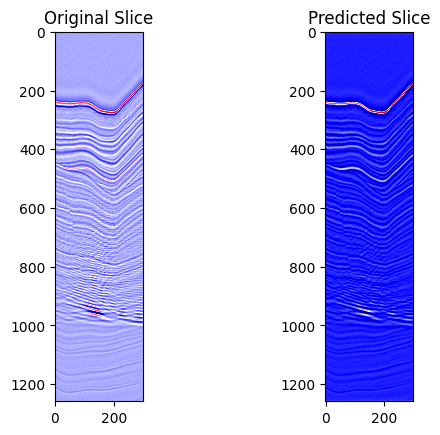

Epoch [1/200], Train Loss: 9798.1797, Train SSIM: 0.4765,           Val Loss: 9838.8150, Val SSIM: 0.4669


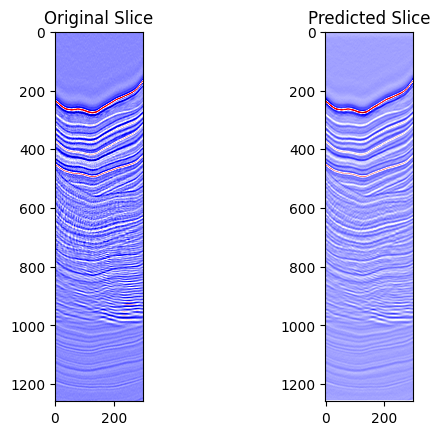

Epoch [2/200], Train Loss: 9750.7943, Train SSIM: 0.4800,           Val Loss: 9995.3192, Val SSIM: 0.4668


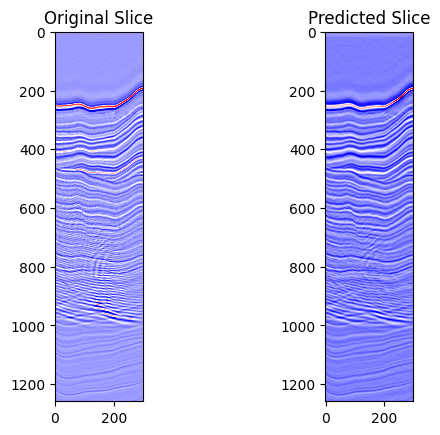

Epoch [3/200], Train Loss: 9735.0352, Train SSIM: 0.4806,           Val Loss: 369730715.6123, Val SSIM: 0.6428


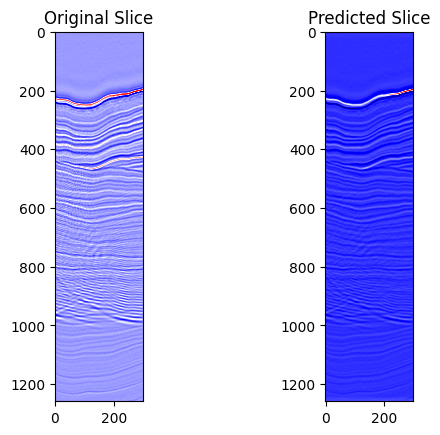

Epoch [4/200], Train Loss: 9732.4460, Train SSIM: 0.4809,           Val Loss: 10154.5822, Val SSIM: 0.4624


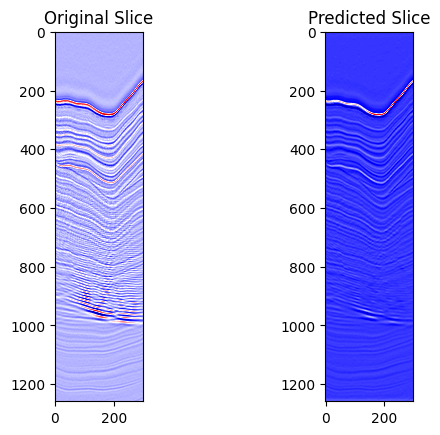

Epoch [5/200], Train Loss: 9719.1588, Train SSIM: 0.4816,           Val Loss: 9952.3644, Val SSIM: 0.4675


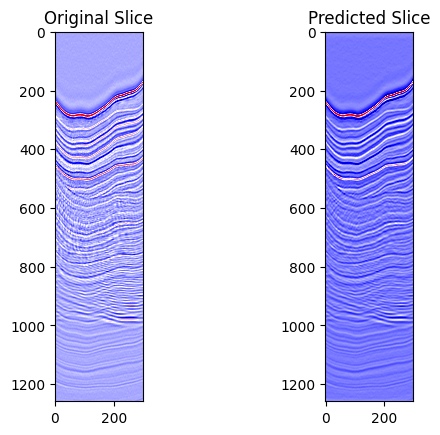

Epoch [6/200], Train Loss: 9712.4753, Train SSIM: 0.4823,           Val Loss: 9786.4999, Val SSIM: 0.4711


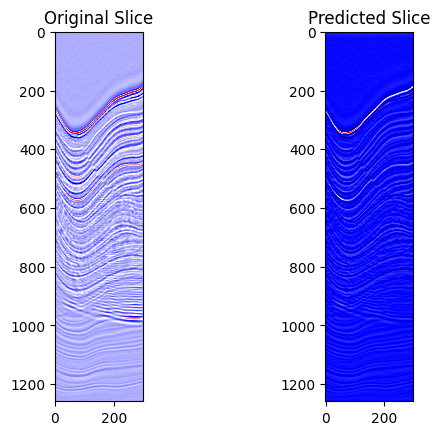

Epoch [7/200], Train Loss: 9690.8905, Train SSIM: 0.4821,           Val Loss: 9705.1649, Val SSIM: 0.4751


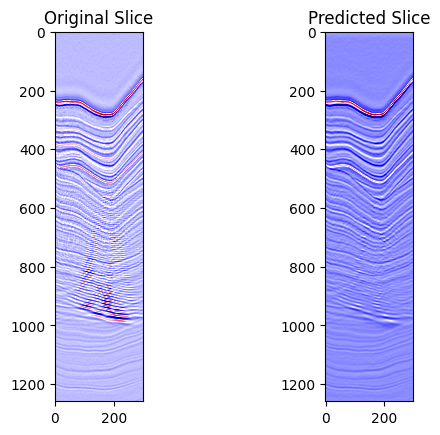

Epoch [8/200], Train Loss: 9675.4340, Train SSIM: 0.4814,           Val Loss: 9726.5142, Val SSIM: 0.4678


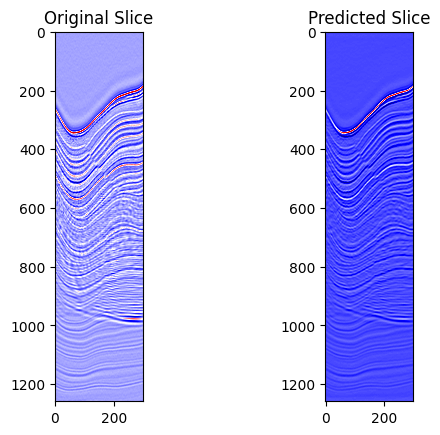

Epoch [9/200], Train Loss: 9658.7146, Train SSIM: 0.4817,           Val Loss: 9745.9561, Val SSIM: 0.4576


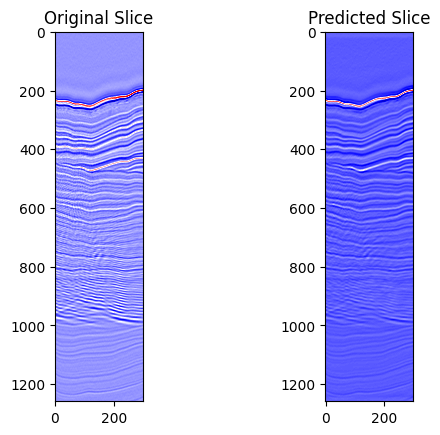

Epoch [10/200], Train Loss: 9639.1777, Train SSIM: 0.4828,           Val Loss: 9688.7871, Val SSIM: 0.4787


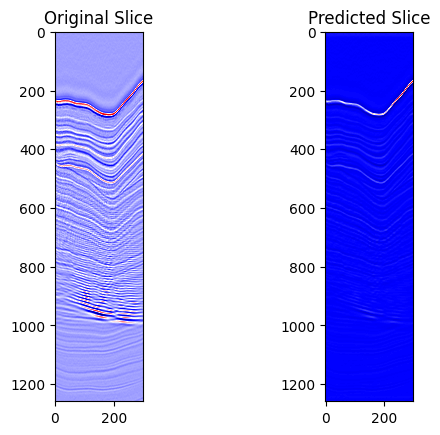

Epoch [11/200], Train Loss: 9620.2222, Train SSIM: 0.4840,           Val Loss: 9793.6804, Val SSIM: 0.4681


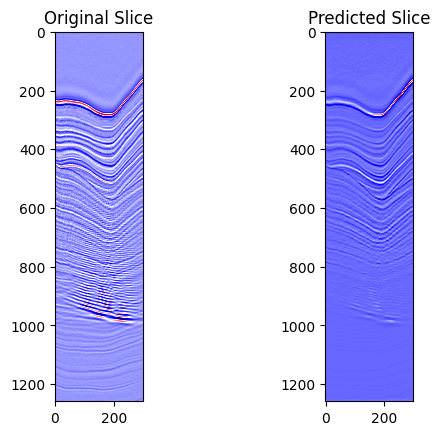

Epoch [12/200], Train Loss: 9588.5575, Train SSIM: 0.4850,           Val Loss: 9568.7902, Val SSIM: 0.4820


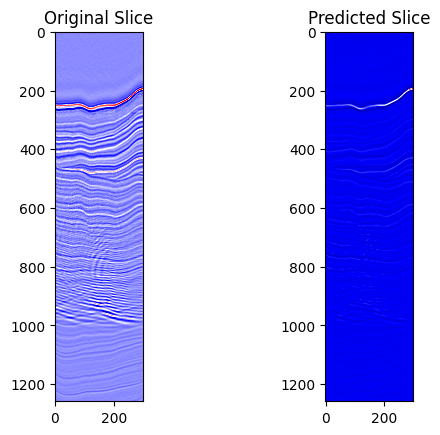

Epoch [13/200], Train Loss: 9559.2839, Train SSIM: 0.4863,           Val Loss: 9566.6401, Val SSIM: 0.4805


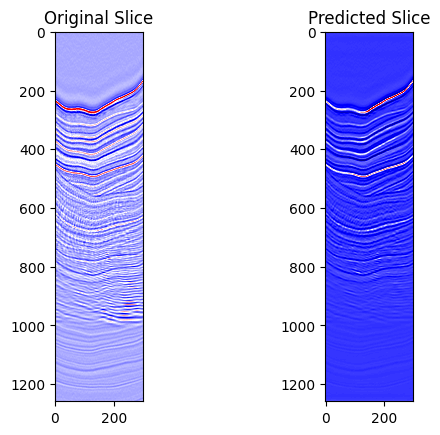

Epoch [14/200], Train Loss: 9526.7409, Train SSIM: 0.4859,           Val Loss: 9606.3489, Val SSIM: 0.4738


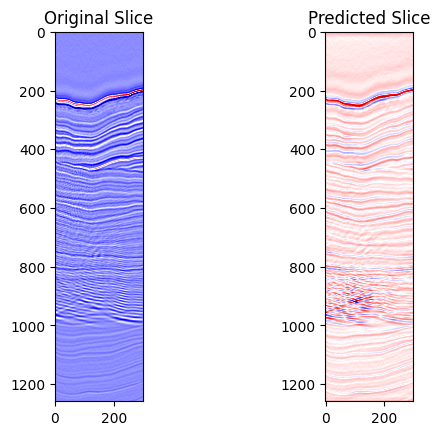

Epoch [15/200], Train Loss: 9471.9530, Train SSIM: 0.4871,           Val Loss: 9508.3447, Val SSIM: 0.4830


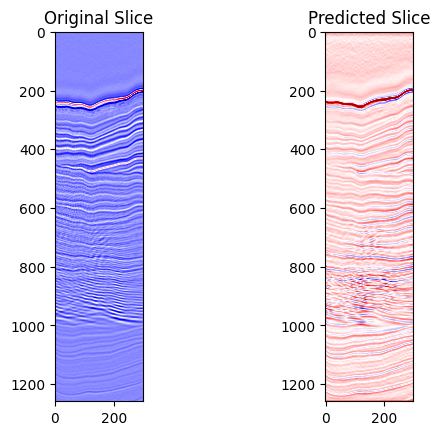

Epoch [16/200], Train Loss: 9431.1127, Train SSIM: 0.4886,           Val Loss: 9520.7982, Val SSIM: 0.4826


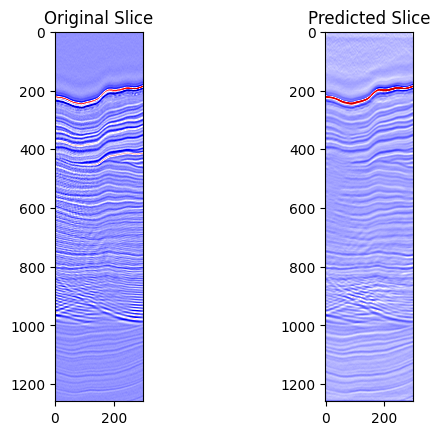

Epoch [17/200], Train Loss: 9378.8922, Train SSIM: 0.4897,           Val Loss: 9483.3325, Val SSIM: 0.4840


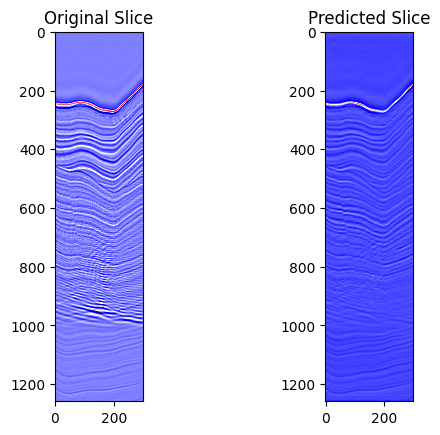

Epoch [18/200], Train Loss: 9353.3841, Train SSIM: 0.4898,           Val Loss: 9620.9564, Val SSIM: 0.4792


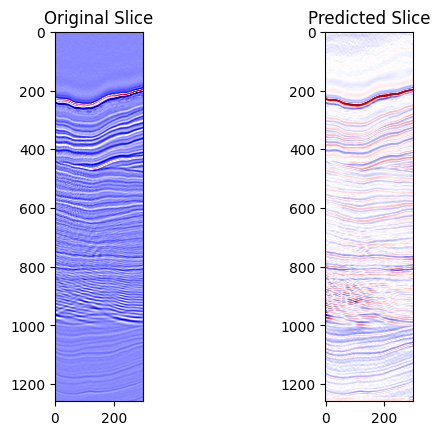

Epoch [19/200], Train Loss: 9288.1323, Train SSIM: 0.4928,           Val Loss: 9546.0628, Val SSIM: 0.4806


KeyboardInterrupt: 

In [ ]:
# # Number of epochs
# num_epochs = 200

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     running_ssim = 0.0

#     for x_batch, y_batch in train_loader:
#         optimizer.zero_grad()
#         outputs = model(x_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#         batch_ssim = ssim_metric(outputs.detach(), y_batch.detach())
#         running_ssim += batch_ssim.item()

#     # Validation phase
#     model.eval()
#     val_loss = 0.0
#     val_ssim = 0.0
#     with torch.no_grad():
#         for x_val, y_val in val_loader:
#             val_outputs = model(x_val)
#             val_loss += criterion(val_outputs, y_val).item()
#             val_ssim += ssim_metric(val_outputs, y_val).item()

#     # Prediction on a single slice from X_slices_t
#     random_slice = X_slices_t[torch.randint(0, len(X_slices_t), (1,)).item()]

#     # Convert to PyTorch tensor and add batch and channel dimensions
#     random_slice = torch.tensor(random_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

#     prediction = model(random_slice).detach()

#     # Visualize the original and predicted slice
#     plt.subplot(1, 2, 1)
#     plt.title("Original Slice")
#     plt.imshow(random_slice.squeeze().cpu().numpy(), cmap='seismic')

#     plt.subplot(1, 2, 2)
#     plt.title("Predicted Slice")
#     plt.imshow(prediction.squeeze().cpu().numpy(), cmap='seismic')
#     plt.show()

#     print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Train SSIM: {running_ssim / len(train_loader):.4f}, \
#           Val Loss: {val_loss / len(val_loader):.4f}, Val SSIM: {val_ssim / len(val_loader):.4f}")


# print("Training complete!")